# A. Importation of libraries and Configs

In [7]:
# Standard libraries
import pandas as pd
import numpy as np
from datetime import datetime

In [8]:
class Config:
    # Path to the pseudonimized revenues dataset
    dataset_dir = r"Database\revenues_pseudonymized.xlsx"
    # Path to the enrollee infos
    enrollees_dir = r"Database\enrollees_pseudonymized.xlsx"
    # Path to the machine learning model parameters
    parameters_dir = r"MachineLearning\parameters.json"

    # Path to cache directory to store preprocessed dataset if needed
    cache_dir = ""
    load_cache = True

    # Path to store transformer results
    results_dir = r"C:\Users\rjbel\Python\Data\Thesis\Results"


    # The date used
    observation_end = datetime.today()

    # Class to predict
    target_feature = 'dtp_bracket'
    # Test size in %
    test_size = 0.3

    # Time points used in generating survival features
    # It's not until 120 since the earliest pre-payment is 288 days
    time_points = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450]


args = Config()

# B. Loading of datasets

## 1. Revenues

In [9]:
df_revenues = pd.read_excel(args.dataset_dir)

In [10]:
df_revenues

,entry_number,entry_date,due_date,school_year,student_id_pseudonimized,category_name,discount_refund_applied_to,amount_due,amount_paid,account_name,receivables
0,0,2025-10-13,2025-10-13,2014,9XBPS6GQ,Form 137,NaN,150.0,150.0,G-Cash,0.0
1,1,2016-01-01,2016-01-01,2016,QCNXOF71,Back Account,NaN,3524.0,0.0,Not Applicable,3524.0
2,2,2016-01-01,2016-01-01,2016,UFN5RBCA,Back Account,NaN,9831.0,0.0,Not Applicable,9831.0
3,3,2016-01-01,2016-01-01,2016,CATF26JR,Back Account,NaN,9240.0,0.0,Not Applicable,9240.0
4,4,2016-01-01,2016-01-01,2016,TE11Z2LJ,Back Account,NaN,5886.0,0.0,Not Applicable,5886.0
...,...,...,...,...,...,...,...,...,...,...,...
51747,53755,2026-02-27,2026-08-07,2026,HAHX9ZRO,G02-B-1st,NaN,7500.0,0.0,Not Applicable,7500.0
51748,53756,2026-02-27,2026-11-06,2026,HAHX9ZRO,G02-B-2nd,NaN,7500.0,0.0,Not Applicable,7500.0
51749,53757,2026-02-27,2026-08-07,2026,HAHX9ZRO,G02-OF-1st,NaN,5467.0,0.0,Not Applicable,5467.0
51750,53758,2026-02-27,2026-12-04,2026,HAHX9ZRO,G02-OF-2nd,NaN,5467.0,0.0,Not Applicable,5467.0


## 2. Enrollees

In [11]:
df_enrollees = pd.read_excel(args.enrollees_dir)

## 3. Credit Sales

In [12]:
from FeatureEngineering.credit_sales_machine_learning import CreditSales

cs = CreditSales(df_revenues, df_enrollees, args)
df_credit_sales = cs.show_data()

Single due date records: 10087
Multiple due date records: 255


c:\Users\rjbel\Python\Notebooks\Mapua\Thesis\FeatureEngineering\credit_sales_machine_learning.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return trend.fillna(0)
c:\Users\rjbel\Python\Notebooks\Mapua\Thesis\FeatureEngineering\credit_sales_machine_learning.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return trend.fillna(0)
c:\Users\rjbel\Python\Notebooks\Mapua\Thesis\FeatureEngineering\credit_sales_machine_learning.py:703: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [13]:
df_credit_sales

,school_year,student_id_pseudonimized,category_name,gross_receivables,amount_discounted,adjustments,credit_sale_amount,due_date,date_fully_paid,days_elapsed_until_fully_paid,...,amount_paid_cumsum,opening_balance,plan_type_Plan - A,plan_type_Plan - B,plan_type_Plan - C,plan_type_Plan - D,plan_type_Plan - E,plan_type_nan,dtp_bracket,censor
0,2016,CATF26JR,Back Account,9240.0,0.0,0.0,9240.0,2016-01-01,2019-02-06,1132,...,0.0,9240.0,0.0,0.0,0.0,0.0,0.0,1.0,90_days,1
1,2016,QCNXOF71,Back Account,3524.0,0.0,0.0,3524.0,2016-01-01,2019-01-31,1126,...,0.0,3524.0,0.0,0.0,0.0,0.0,0.0,1.0,90_days,1
2,2016,LI5DFHZ5,Back Account,5650.0,0.0,0.0,5650.0,2016-01-01,2021-01-29,1855,...,0.0,5650.0,0.0,0.0,0.0,0.0,0.0,1.0,90_days,1
3,2016,TE11Z2LJ,Back Account,5886.0,0.0,0.0,5886.0,2016-01-01,2019-03-11,1165,...,0.0,5886.0,0.0,0.0,0.0,0.0,0.0,1.0,90_days,1
4,2016,UFN5RBCA,Back Account,9831.0,0.0,0.0,9831.0,2016-01-01,2019-04-26,1211,...,0.0,9831.0,0.0,0.0,0.0,0.0,0.0,1.0,90_days,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10177,2026,5NX2Y86F,G09-OF-Full,18800.0,0.0,0.0,18800.0,2026-07-11,2026-02-02,-159,...,338521.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,on_time,1
10178,2026,D9L1401L,G06-OF-Full,10000.0,0.0,0.0,10000.0,2026-07-11,2026-01-31,-161,...,230000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,on_time,1
10179,2026,L1RIQ6A4,G02-A-UE,15600.0,-3680.0,0.0,11920.0,2026-07-11,2026-01-26,-166,...,248238.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,on_time,1
10180,2026,L1RIQ6A4,G02-OF-Full,16400.0,0.0,0.0,16400.0,2026-07-11,2026-01-26,-166,...,248238.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,on_time,1


# C. Exploratory Data Analysis

In [14]:
# Get counts
counts = df_credit_sales.dtp_bracket.value_counts()

# Convert to percentages
percentages = counts / counts.sum() * 100

# Combine into one DataFrame
result = pd.DataFrame({
    'count': counts,
    'percentage': percentages.round(2)
})

print(result)

             count  percentage
dtp_bracket                   
on_time       3761       40.12
30_days       2753       29.37
90_days       1809       19.30
60_days       1051       11.21


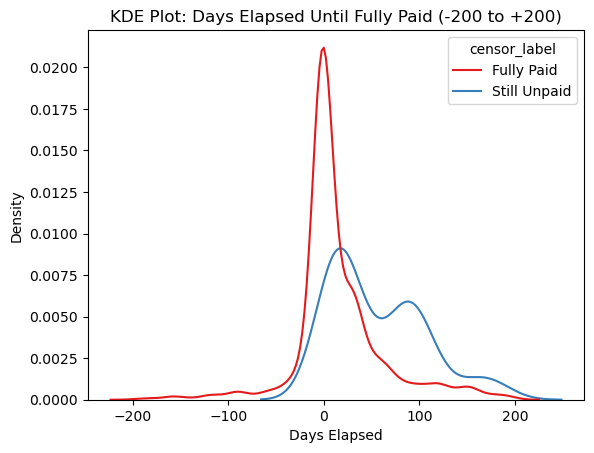

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Remove those that have no full dtp_history:
df_filtered = df_credit_sales.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'])


# Clean and filter directly on the DataFrame
df_filtered = df_filtered.loc[
    df_filtered['days_elapsed_until_fully_paid']
        .replace("", np.nan)   # replace empty strings with NaN
        .dropna()              # drop NaNs
        .index                 # keep aligned index
]


# Apply numeric filter
df_filtered = df_filtered[
    (df_filtered['days_elapsed_until_fully_paid'] >= -200) &
    (df_filtered['days_elapsed_until_fully_paid'] <= 200)
]

# Convert censor column to categorical with labels
df_filtered["censor_label"] = (
    df_filtered["censor"]
    .map({0: "Still Unpaid", 1: "Fully Paid"})
    .astype("category")   # force categorical type
)


# KDE plot with grouping by categorical censor labels
sns.kdeplot(
    data=df_filtered,
    x="days_elapsed_until_fully_paid",
    hue="censor_label",
    fill=False,
    common_norm=False,
    palette="Set1"
)

plt.title("KDE Plot: Days Elapsed Until Fully Paid (-200 to +200)")
plt.xlabel("Days Elapsed")
plt.ylabel("Density")
plt.show()

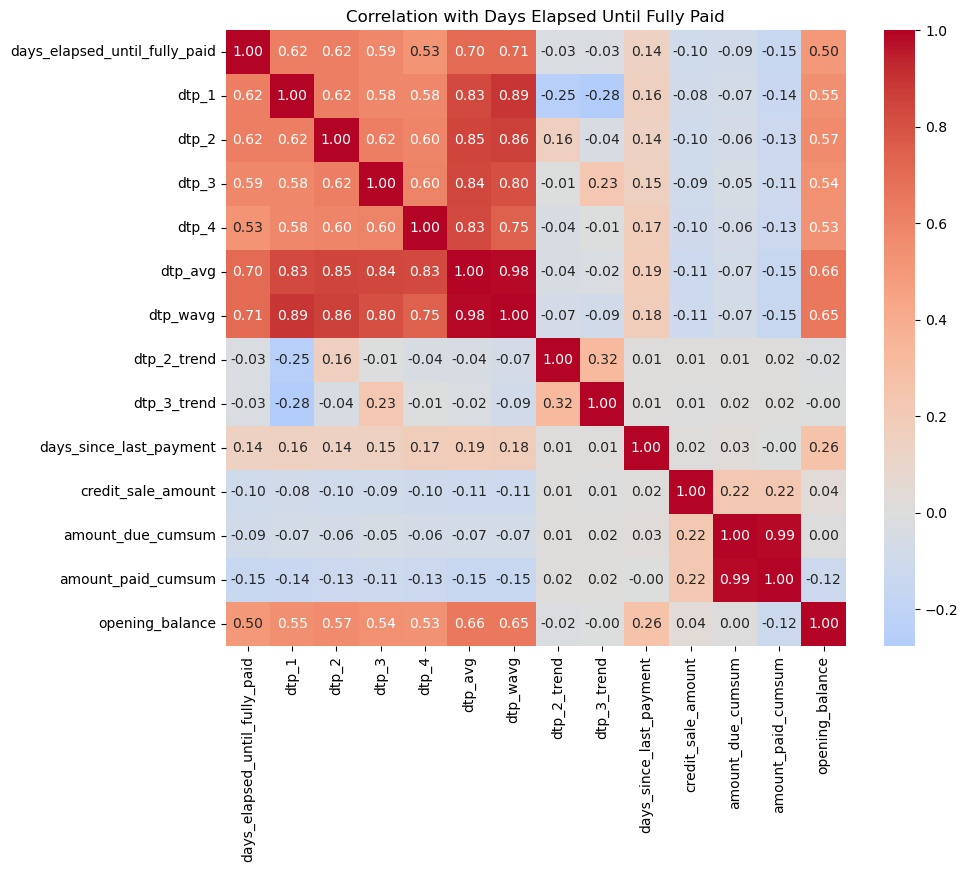

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered = df_credit_sales[df_credit_sales['censor'] == 1]
df_filtered = df_filtered.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'])

# Select relevant columns
cols = ['days_elapsed_until_fully_paid', 
        'dtp_1', 'dtp_2', 'dtp_3', 'dtp_4', 
        'dtp_avg', 'dtp_wavg', 'dtp_2_trend',
        'dtp_3_trend', 'days_since_last_payment',
        'credit_sale_amount', 'amount_due_cumsum',
        'amount_paid_cumsum', 'opening_balance']

# Compute correlation matrix
corr = df_filtered[cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation with Days Elapsed Until Fully Paid")
plt.show()

# D. Machine Learning Pipelines

## 1. Survival Analysis Sandbox

### a. Step by step pipeline

In [17]:
drop_columns = ['school_year', 'student_id_pseudonimized', 'category_name',
       'gross_receivables', 'amount_discounted', 'adjustments', 'due_date_prev_1',
       'due_date_prev_2', 'date_fully_paid', 'last_payment_date',
       'plan_type_Plan - D', 'plan_type_Plan - E', 'plan_type_nan']

#drop_columns = drop_columns + ['credit_sale_amount', 'amount_due_cumsum', 'amount_paid_cumsum']
drop_columns = drop_columns + ['plan_type_Plan - A', 'plan_type_Plan - B', 'plan_type_Plan - C']

df_data = df_credit_sales[df_credit_sales['censor'] == 1]

df_data = df_data.drop(columns=drop_columns)
df_data.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'], inplace=True)
df_data

,credit_sale_amount,due_date,days_elapsed_until_fully_paid,dtp_1,dtp_2,dtp_3,dtp_4,dtp_avg,dtp_wavg,dtp_2_trend,dtp_3_trend,days_since_last_payment,amount_due_cumsum,amount_paid_cumsum,opening_balance,dtp_bracket,censor
83,11580.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
84,4500.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
86,2700.0,2018-06-04,365,365,365,365,519,403.5,380.4,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
89,2700.0,2018-06-04,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days,1
113,4500.0,2018-06-15,344,344,276,344,344,327.0,323.6,0.000000,0.000000,15,31002.0,8395.0,22607.0,90_days,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10174,3850.0,2026-07-11,-161,-3,-3,2,3,-0.25,-1.4,0.000000,0.005285,161,223810.0,223810.0,0.0,on_time,1
10176,8300.0,2026-07-11,-162,293,1,260,30,146.0,172.5,-0.555133,-0.031309,145,266474.0,266474.0,0.0,on_time,1
10177,18800.0,2026-07-11,-159,0,130,-51,204,70.75,49.2,0.179558,-0.042079,164,338521.0,338521.0,0.0,on_time,1
10179,11920.0,2026-07-11,-166,7,7,-2,-5,1.75,4.0,0.000000,-0.053254,148,248238.0,248238.0,0.0,on_time,1


In [18]:
drop_columns = ['school_year', 'student_id_pseudonimized', 'category_name',
       'gross_receivables', 'amount_discounted', 'adjustments', 'due_date',
       'due_date_prev_1', 'due_date_prev_2', 'date_fully_paid', 'last_payment_date',
       'plan_type_Plan - D', 'plan_type_Plan - E', 'plan_type_nan', 'dtp_bracket']

drop_columns = drop_columns + ['plan_type_Plan - A', 'plan_type_Plan - B', 'plan_type_Plan - C']

df_data_surv = df_credit_sales.drop(columns=drop_columns)
df_data_surv.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'], inplace=True)
df_data_surv

,credit_sale_amount,days_elapsed_until_fully_paid,dtp_1,dtp_2,dtp_3,dtp_4,dtp_avg,dtp_wavg,dtp_2_trend,dtp_3_trend,days_since_last_payment,amount_due_cumsum,amount_paid_cumsum,opening_balance,censor
83,11580.0,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,1
84,4500.0,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,1
86,2700.0,365,365,365,365,519,403.5,380.4,0.000000,0.000000,-1,39594.0,5000.0,34594.0,1
89,2700.0,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,1
113,4500.0,344,344,276,344,344,327.0,323.6,0.000000,0.000000,15,31002.0,8395.0,22607.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10174,3850.0,-161,-3,-3,2,3,-0.25,-1.4,0.000000,0.005285,161,223810.0,223810.0,0.0,1
10176,8300.0,-162,293,1,260,30,146.0,172.5,-0.555133,-0.031309,145,266474.0,266474.0,0.0,1
10177,18800.0,-159,0,130,-51,204,70.75,49.2,0.179558,-0.042079,164,338521.0,338521.0,0.0,1
10179,11920.0,-166,7,7,-2,-5,1.75,4.0,0.000000,-0.053254,148,248238.0,248238.0,0.0,1


In [19]:
X = df_data_surv.drop(columns=['days_elapsed_until_fully_paid', 'censor'])
T = df_data_surv['days_elapsed_until_fully_paid']
E = df_data_surv['censor']

# Avoid negative values by shifting by the days of pre-paid period
earliest_pre_payment = np.minimum(T, 0) # Maximum to only get pre-payments
ε = 1e-6 # Used to avoid zero values
T = T - earliest_pre_payment + ε

In [20]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostClassifier
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

from MachineLearning.Utils.generate_survival_features import generate_survival_features

# ============================================
# STEP 0 — Initialize and Prepare Data
# ============================================

# Build survival array
survival_train = np.array(
    [(bool(e), float(t)) for e, t in zip(E.values, T.values)],
    dtype=[('event', 'bool'), ('time', 'float')]
)

# ============================================
# STEP 1 — Tune Survival Model
# ============================================
penalties = [1e-4, 1e-3, 1e-2, 1e-1, 1]
best_penalty, best_c_index = None, -np.inf

for λ in penalties:
    model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[λ])
    model.fit(X, survival_train)
    risk_scores = model.predict(X)
    c_index = concordance_index_censored(E.astype(bool), T, risk_scores)[0]
    if c_index > best_c_index:
        best_penalty, best_c_index = λ, c_index

print("Best Penalty:", best_penalty, "Best C-index:", best_c_index)

# ============================================
# STEP 2 — Retrain Survival Model
# ============================================
survival_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[best_penalty])
survival_model.fit(X, survival_train)

c:\Users\rjbel\anaconda3\envs\thesis_ippp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Best Penalty: 1 Best C-index: 0.768305475182013


,n_alphas,100
,alphas,[1]
,alpha_min_ratio,'auto'
,l1_ratio,1.0
,penalty_factor,None
,normalize,False
,copy_X,True
,tol,1e-07
,max_iter,100000
,verbose,False
,fit_baseline_model,False


In [ ]:
from MachineLearning.Utils.data_preparation import DataPreparer

preparer = DataPreparer(df_data,
                                target_feature=args.target_feature,
                                test_size=args.test_size)
preparer.prep_data(balance_strategy="borderline_smote")

X_train = preparer.X_train
X_test = preparer.X_test
y_train = preparer.y_train
y_test = preparer.y_test

Partitioning datasets based on due_date...
Applying borderline_smote...


In [22]:
df_survival_train, df_survival_test = generate_survival_features(df_data_surv, T, E, X_train, X_test, best_penalty, time_points=args.time_points)

In [23]:
parameters = {
    "learning_rate": 0.1,
    "n_estimators": 50,
    "random_state": 42
}

In [ ]:
from MachineLearning.Utils.data_preparation import DataPreparer 
from MachineLearning import AdaBoostPipeline

preparer = DataPreparer(df_data, args.target_feature, test_size=args.test_size, verbose=False)
preparer.prep_data(balance_strategy="borderline_smote")

X_train, X_test = preparer.X_train, preparer.X_test
y_train, y_test = preparer.y_train, preparer.y_test

pipeline = AdaBoostPipeline(
    X_train, X_test, y_train, y_test,
    args,
    parameters
)

# Capture results from pipeline
result = pipeline.initialize_model().fit(use_feature_selection=True).evaluate().show_results()
result

{'accuracy': 0.6483942414174972,
 'precision_macro': 0.29621309370988447,
 'recall_macro': 0.5,
 'f1_macro': 0.3280065005417118,
 'roc_auc_macro': 0.8406749645959908}

In [25]:
from MachineLearning.Utils.data_preparation import DataPreparer
from MachineLearning import AdaBoostPipeline

pipeline = AdaBoostPipeline(
    df_survival_train, df_survival_test, y_train, y_test,
    args,
    parameters
)

# Capture results from pipeline
result = pipeline.initialize_model().fit(use_feature_selection=True).evaluate().show_results()
result

{'accuracy': 0.6483942414174972,
 'precision_macro': 0.29621309370988447,
 'recall_macro': 0.5,
 'f1_macro': 0.3280065005417118,
 'roc_auc_macro': 0.8406749645959908}

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostClassifier
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

from MachineLearning.Utils.generate_survival_features import generate_survival_features

# ============================================
# STEP 0 — Initialize and Prepare Data
# ============================================

# Build survival array
survival_train = np.array(
    [(bool(e), float(t)) for e, t in zip(E.values, T.values)],
    dtype=[('event', 'bool'), ('time', 'float')]
)

# ============================================
# STEP 1 — Tune Survival Model
# ============================================
penalties = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
best_penalty, best_c_index = None, -np.inf

for λ in penalties:
    model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[λ])
    model.fit(X, survival_train)
    risk_scores = model.predict(X)
    c_index = concordance_index_censored(E.astype(bool), T, risk_scores)[0]
    if c_index > best_c_index:
        best_penalty, best_c_index = λ, c_index

print("Best Penalty:", best_penalty, "Best C-index:", best_c_index)

# ============================================
# STEP 2 — Retrain Survival Model
# ============================================
survival_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[best_penalty])
survival_model.fit(df_data_surv, survival_train)

# ============================================
# STEP 3 — Generate Survival Features
# ============================================
df_survival_train, df_survival_test = generate_survival_features(X, T, E, X_train, X_test, best_penalty, time_points=args.time_points)

# ============================================
# STEP 4 — Train Classifier (baseline vs survival)
# ============================================
# Baseline classifier (raw features, full dataset)
baseline_clf = AdaBoostClassifier(**parameters)
baseline_clf.fit(X_train, y_train)
baseline_pred = baseline_clf.predict(X_test)
baseline_f1 = f1_score(y_test, baseline_pred, average="macro")

# Survival-feature classifier (restricted subset)
clf = AdaBoostClassifier(**parameters)
clf.fit(df_survival_train, y_train)
survival_pred = clf.predict(df_survival_test)
survival_f1 = f1_score(y_test, survival_pred, average="macro")

print("Baseline F1:", baseline_f1)
print("Survival F1:", survival_f1)

# ============================================
# STEP 5 — Feature Selection + Final Classifier
# ============================================
selector = SelectFromModel(clf, prefit=True)
X_train_selected = selector.transform(df_survival_train)
X_test_selected  = selector.transform(df_survival_test)

final_clf = AdaBoostClassifier(**parameters)
final_clf.fit(X_train_selected, y_train)
final_pred = final_clf.predict(X_test_selected)
final_f1 = f1_score(y_test, final_pred, average="macro")

print("Final F1 Score:", final_f1)

Best Penalty: 1 Best C-index: 0.768305475182013
Baseline F1: 0.3280065005417118
Survival F1: 0.3280065005417118
Final F1 Score: 0.3280065005417118


c:\Users\rjbel\anaconda3\envs\thesis_ippp\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\rjbel\anaconda3\envs\thesis_ippp\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


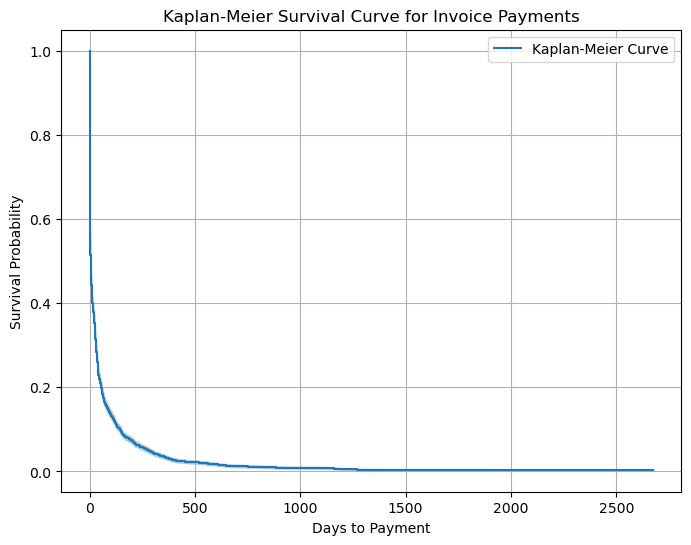

In [27]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# ============================================
# STEP X — Plot Kaplan-Meier Survival Curve
# ============================================

# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the model on your training data
kmf.fit(durations=T,
        event_observed=E,
        label="Kaplan-Meier Curve")

# Plot the survival function
plt.figure(figsize=(8,6))
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curve for Invoice Payments")
plt.xlabel("Days to Payment")
plt.ylabel("Survival Probability")
#plt.xlim(100, 500)
plt.grid(True)
plt.show()

### b. Unedited full pipeline

In [28]:
if False:
    import numpy as np
    from sklearn.metrics import f1_score
    from sklearn.feature_selection import SelectFromModel
    from sklearn.ensemble import RandomForestClassifier
    from sksurv.linear_model import CoxnetSurvivalAnalysis
    from sksurv.metrics import concordance_index_censored

    # ============================================
    # STEP 0 — Prepare Data
    # ============================================
    # X: feature matrix (DataFrame)
    # T: time-to-event (array)
    # E: event indicator (array, 1=event occurred, 0=censored)
    # Y: classification labels (array)

    drop_columns = ['school_year', 'student_id_pseudonimized', 'category_name',
        'gross_receivables', 'amount_discounted', 'adjustments', 'due_date',
        'due_date_prev_1', 'due_date_prev_2', 'date_fully_paid', 'last_payment_date',
        'plan_type_Plan - D', 'plan_type_Plan - E', 'plan_type_nan', 'dtp_bracket']

    drop_columns = drop_columns + ['plan_type_Plan - A', 'plan_type_Plan - B', 'plan_type_Plan - C']

    df_data_surv = df_credit_sales.drop(columns=drop_columns)
    df_data_surv.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'], inplace=True)
    df_data_surv


    X = df_data_surv.drop(columns=['days_elapsed_until_fully_paid', 'censor'])
    T = df_data_surv['days_elapsed_until_fully_paid']
    E = df_data_surv['censor']
    Y = df_data[args.target_feature]

    # Avoid negative values by shifting by the days of pre-paid period
    earliest_pre_payment = np.minimum(T, 0) # Maximum to only get pre-payments
    ε = 1e-6 # Used to avoid zero values
    T = T - earliest_pre_payment + ε



    # Convert to structured array for scikit-survival
    survival_data = np.array([(bool(e), t) for e, t in zip(E, T)],
                            dtype=[('event', 'bool'), ('time', 'float')])

    # ============================================
    # STEP 1 — Define Candidate Penalties
    # ============================================
    penalties = [1e-4, 1e-3, 1e-2, 1e-1, 1]

    best_penalty = None
    best_c_index = -np.inf

    # ============================================
    # STEP 2 — Tune Survival Model
    # ============================================
    for λ in penalties:
        model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[λ])
        model.fit(X, survival_data)
        
        risk_scores = model.predict(X)
        c_index = concordance_index_censored(E.astype(bool), T, risk_scores)[0]
        
        if c_index > best_c_index:
            best_c_index = c_index
            best_penalty = λ

    print("Best Penalty:", best_penalty, "Best C-index:", best_c_index)

    # ============================================
    # STEP 3 — Retrain Survival Model
    # ============================================
    survival_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[best_penalty])
    survival_model.fit(X, survival_data)

    # ============================================
    # STEP 4 — Generate Survival-Based Features
    # ============================================
    df_survival = generate_survival_features(X, T, E, X_train, X_test, best_penalty)

    # ============================================
    # STEP 5 — Train Initial Classifier
    # ============================================
    clf = RandomForestClassifier(random_state=42)
    clf.fit(df_survival, survival_train)

    # Evaluate initial classifier
    Y_pred_initial = clf.predict(df_survival)
    f1_initial = f1_score(Y, Y_pred_initial, average="macro")
    print("Initial F1 Score:", f1_initial)

    # ============================================
    # STEP 6 — Feature Selection
    # ============================================
    selector = SelectFromModel(clf, prefit=True)
    X_selected = selector.transform(df_survival)

    # ============================================
    # STEP 7 — Train Final Classifier
    # ============================================
    final_clf = RandomForestClassifier(random_state=42)
    final_clf.fit(X_selected, Y)

    # ============================================
    # STEP 8 — Predictions
    # ============================================
    Y_pred_final = final_clf.predict(X_selected)
    f1_final = f1_score(Y, Y_pred_final, average="macro")

    print("Final F1 Score:", f1_final)


## 2. Enhanced with Survival Features

### a. Calculating the best penalty (λ) 

In [29]:
drop_columns = ['school_year', 'student_id_pseudonimized', 'category_name',
       'gross_receivables', 'amount_discounted', 'adjustments', 'due_date',
       'due_date_prev_1', 'due_date_prev_2', 'date_fully_paid', 'last_payment_date']

drop_columns = drop_columns + ['plan_type_Plan - A', 'plan_type_Plan - B', 'plan_type_Plan - C',
                               'plan_type_Plan - D', 'plan_type_Plan - E', 'plan_type_nan']

drop_columns = drop_columns + [args.target_feature]

df_data_surv = df_credit_sales.drop(columns=drop_columns)
df_data_surv.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'], inplace=True)
df_data_surv

,credit_sale_amount,days_elapsed_until_fully_paid,dtp_1,dtp_2,dtp_3,dtp_4,dtp_avg,dtp_wavg,dtp_2_trend,dtp_3_trend,days_since_last_payment,amount_due_cumsum,amount_paid_cumsum,opening_balance,censor
83,11580.0,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,1
84,4500.0,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,1
86,2700.0,365,365,365,365,519,403.5,380.4,0.000000,0.000000,-1,39594.0,5000.0,34594.0,1
89,2700.0,365,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,1
113,4500.0,344,344,276,344,344,327.0,323.6,0.000000,0.000000,15,31002.0,8395.0,22607.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10174,3850.0,-161,-3,-3,2,3,-0.25,-1.4,0.000000,0.005285,161,223810.0,223810.0,0.0,1
10176,8300.0,-162,293,1,260,30,146.0,172.5,-0.555133,-0.031309,145,266474.0,266474.0,0.0,1
10177,18800.0,-159,0,130,-51,204,70.75,49.2,0.179558,-0.042079,164,338521.0,338521.0,0.0,1
10179,11920.0,-166,7,7,-2,-5,1.75,4.0,0.000000,-0.053254,148,248238.0,248238.0,0.0,1


In [30]:
from sklearn.preprocessing import LabelEncoder

target_feature = args.target_feature

# Encode the labels
label_encoder = LabelEncoder()

# Extract variables for training the survival model
X = df_data_surv.drop(columns=['days_elapsed_until_fully_paid', 'censor'])
T = df_data_surv['days_elapsed_until_fully_paid']
E = df_data_surv['censor']

# Avoid negative values by shifting by the days of pre-paid period
earliest_pre_payment = np.minimum(T, 0) # Maximum to only get pre-payments
ε = 1e-6 # Used to avoid zero values
T = T - earliest_pre_payment + ε

In [31]:
import numpy as np
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

from MachineLearning.Utils.generate_survival_features import generate_survival_features

# ============================================
# STEP 0 — Initialize and Prepare Data
# ============================================

# Build survival array
survival_train = np.array(
    [(bool(e), float(t)) for e, t in zip(E.values, T.values)],
    dtype=[('event', 'bool'), ('time', 'float')]
)

# ============================================
# STEP 1 — Tune Survival Model
# ============================================
penalties = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
best_penalty, best_c_index = None, -np.inf

for λ in penalties:
    model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[λ], normalize=True)
    model.fit(X, survival_train)
    risk_scores = model.predict(X)
    c_index = concordance_index_censored(E.astype(bool), T, risk_scores)[0]
    if c_index > best_c_index:
        best_penalty, best_c_index = λ, c_index

print(f"Best Penalty: {best_penalty} | Best C-index: {best_c_index}")

# ============================================
# STEP 2 — Retrain Survival Model
# ============================================
survival_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[best_penalty])
survival_model.fit(X, survival_train)

C:\Users\rjbel\AppData\Local\Temp\ipykernel_27528\1403656795.py:25: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X, survival_train)
C:\Users\rjbel\AppData\Local\Temp\ipykernel_27528\1403656795.py:25: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X, survival_train)
C:\Users\rjbel\AppData\Local\Temp\ipykernel_27528\1403656795.py:25: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X, survival_train)


Best Penalty: 0.001 | Best C-index: 0.7801032381976306


,n_alphas,100
,alphas,[0.001]
,alpha_min_ratio,'auto'
,l1_ratio,1.0
,penalty_factor,None
,normalize,False
,copy_X,True
,tol,1e-07
,max_iter,100000
,verbose,False
,fit_baseline_model,False


### b. Hyperparameter tuning (various balancing strategies, parameters, and models)

In [32]:
from MachineLearning import (
    AdaBoostPipeline,
    DecisionTreePipeline,
    GaussianNaiveBayesPipeline,
    KnearestNeighborPipeline,
    RandomForestPipeline,
    XGBoostPipeline,
    MultiLayerPerceptronPipeline,
    TransformerPipeline,
)

models = {
    "ada_boost": AdaBoostPipeline,
    "decision_tree": DecisionTreePipeline,
    "gaussian_naive_bayes": GaussianNaiveBayesPipeline,
    "knn": KnearestNeighborPipeline,
    "random_forest": RandomForestPipeline,
    "xgboost": XGBoostPipeline,
    #"nn_mlp": MultiLayerPerceptronPipeline,
    #"nn_rnn": RecurrentNeuralNetworkPipeline,
    #"nn_transformer": TransformerPipeline
}

# Since these models are trained in the GPU, it's best
# to not to parallel compute to avoid bugs
do_not_parallel_compute = ['xg_boost', 'nn_mlp', 'nn_transformer']

In [33]:
from MachineLearning.Utils.generate_thresholds import generate_thresholds

balance_strategies = ["smote", "borderline_smote", "smoteenn", "smotetomek", "hybrid"]

thresholds = generate_thresholds(min_threshold=0.5, max_threshold=0.9, step=0.1)

In [34]:
# To silence the error when running knn:
# UserWarning: Could not find the number of physical cores for the following reason:
# [WinError 2]
import os

os.environ['OMP_NUM_THREADS'] = '16'

In [35]:
# Older method used to debug if there are any changes in the model's code
if False:
    from MachineLearning.Utils.run_models_single_threaded import run_survival_model_experiments

    df_results = run_survival_model_experiments(df_data_surv, models, balance_strategies, args, best_penalty, thresholds)

In [36]:
# Helper columns
drop_columns = ['school_year', 'student_id_pseudonimized', 'category_name',
       'gross_receivables', 'amount_discounted', 'adjustments', 'due_date_prev_1',
       'due_date_prev_2', 'date_fully_paid', 'last_payment_date']

# Payment plans
drop_columns = drop_columns + ['plan_type_Plan - A', 'plan_type_Plan - B', 'plan_type_Plan - C',
                               'plan_type_Plan - D', 'plan_type_Plan - E', 'plan_type_nan']

# Survival related features
drop_columns = drop_columns + ['censor', 'days_elapsed_until_fully_paid']

# Only extract invoices with payments
df_data = df_credit_sales[df_credit_sales['censor'] == 1]

df_data = df_data.drop(columns=drop_columns)

# Drop invoices with missing critical features
df_data.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'], inplace=True)
df_data

,credit_sale_amount,due_date,dtp_1,dtp_2,dtp_3,dtp_4,dtp_avg,dtp_wavg,dtp_2_trend,dtp_3_trend,days_since_last_payment,amount_due_cumsum,amount_paid_cumsum,opening_balance,dtp_bracket
83,11580.0,2018-06-04,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days
84,4500.0,2018-06-04,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days
86,2700.0,2018-06-04,365,365,365,519,403.5,380.4,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days
89,2700.0,2018-06-04,365,365,365,365,365.0,365.0,0.000000,0.000000,-1,39594.0,5000.0,34594.0,90_days
113,4500.0,2018-06-15,344,276,344,344,327.0,323.6,0.000000,0.000000,15,31002.0,8395.0,22607.0,90_days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10174,3850.0,2026-07-11,-3,-3,2,3,-0.25,-1.4,0.000000,0.005285,161,223810.0,223810.0,0.0,on_time
10176,8300.0,2026-07-11,293,1,260,30,146.0,172.5,-0.555133,-0.031309,145,266474.0,266474.0,0.0,on_time
10177,18800.0,2026-07-11,0,130,-51,204,70.75,49.2,0.179558,-0.042079,164,338521.0,338521.0,0.0,on_time
10179,11920.0,2026-07-11,7,7,-2,-5,1.75,4.0,0.000000,-0.053254,148,248238.0,248238.0,0.0,on_time


In [37]:
from MachineLearning.Utils.run_models_parallel import SurvivalExperimentRunner

# Create an experiment runner instance
runner = SurvivalExperimentRunner(
    df_data=df_data,
    df_data_surv=df_data_surv,
    models=models,
    balance_strategies=balance_strategies,
    args=args,
    best_penalty=best_penalty,
    thresholds=thresholds,
    n_jobs=-1,
    do_not_parallel_compute=do_not_parallel_compute,

    output_path="MachineLearning/Results/model_results.xlsx",
    feature_selection_baseline=True,
    feature_selection_enhanced=True
)

# Run experiments
df_results = runner.run()

Running parallel experiments: 100%|██████████| 513/513 [35:00<00:00,  4.09s/exp]  


All results saved to MachineLearning/Results/model_results.xlsx


In [38]:
df_results.sort_values(by='enhanced_accuracy', ascending=False)

,model,parameters,balance_strategy,undersample_threshold,baseline_accuracy,baseline_precision_macro,baseline_recall_macro,baseline_f1_macro,baseline_roc_auc_macro,enhanced_accuracy,enhanced_precision_macro,enhanced_recall_macro,enhanced_f1_macro,enhanced_roc_auc_macro,baseline_features,enhanced_features
401,ada_boost,"{'learning_rate': 0.1, 'n_estimators': 50}",hybrid,0.8,0.775194,0.637272,0.578950,0.592898,0.861193,0.775194,0.637272,0.578950,0.592898,0.861193,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
2,ada_boost,"{'learning_rate': 0.1, 'n_estimators': 50}",smote,NaN,0.774640,0.628592,0.577739,0.589432,0.857072,0.774640,0.628592,0.577739,0.589432,0.857072,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
458,ada_boost,"{'learning_rate': 0.1, 'n_estimators': 50}",hybrid,0.9,0.774640,0.635251,0.577214,0.590943,0.853479,0.774640,0.635251,0.577214,0.590943,0.853479,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
59,ada_boost,"{'learning_rate': 0.1, 'n_estimators': 50}",borderline_smote,NaN,0.771318,0.661172,0.596659,0.609118,0.861752,0.771318,0.661172,0.596659,0.609118,0.861752,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
262,random_forest,"{'max_depth': 20, 'min_samples_leaf': 3, 'n_es...",hybrid,0.5,0.720930,0.523372,0.549495,0.532410,0.859512,0.761905,0.566553,0.585574,0.572779,0.867368,"[credit_sale_amount, dtp_1, dtp_2, dtp_avg, dt...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,knn,"{'n_neighbors': 3, 'weights': 'distance'}",hybrid,0.5,0.558693,0.434051,0.446228,0.417648,0.701336,0.559801,0.433482,0.445223,0.417359,0.702341,"[opening_balance, credit_sale_amount, amount_p...","[opening_balance, credit_sale_amount, amount_p..."
251,knn,"{'n_neighbors': 5, 'weights': 'uniform'}",hybrid,0.5,0.557032,0.446075,0.454759,0.427686,0.728527,0.558693,0.447633,0.456720,0.429077,0.728991,"[opening_balance, credit_sale_amount, amount_p...","[opening_balance, credit_sale_amount, amount_p..."
306,knn,"{'n_neighbors': 3, 'weights': 'uniform'}",hybrid,0.6,0.558693,0.436746,0.450335,0.425268,0.701570,0.558693,0.435216,0.446082,0.423440,0.703399,"[opening_balance, credit_sale_amount, amount_p...","[opening_balance, credit_sale_amount, amount_p..."
121,decision_tree,"{'max_depth': 10, 'min_samples_leaf': 1}",smoteenn,NaN,0.645626,0.508144,0.513646,0.489639,0.747539,0.552602,0.479627,0.485672,0.433725,0.712313,"[credit_sale_amount, dtp_3, dtp_avg, dtp_wavg,...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."


In [39]:
df_results.sort_values(by='enhanced_precision_macro', ascending=False)

,model,parameters,balance_strategy,undersample_threshold,baseline_accuracy,baseline_precision_macro,baseline_recall_macro,baseline_f1_macro,baseline_roc_auc_macro,enhanced_accuracy,enhanced_precision_macro,enhanced_recall_macro,enhanced_f1_macro,enhanced_roc_auc_macro,baseline_features,enhanced_features
59,ada_boost,"{'learning_rate': 0.1, 'n_estimators': 50}",borderline_smote,NaN,0.771318,0.661172,0.596659,0.609118,0.861752,0.771318,0.661172,0.596659,0.609118,0.861752,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
401,ada_boost,"{'learning_rate': 0.1, 'n_estimators': 50}",hybrid,0.8,0.775194,0.637272,0.578950,0.592898,0.861193,0.775194,0.637272,0.578950,0.592898,0.861193,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
458,ada_boost,"{'learning_rate': 0.1, 'n_estimators': 50}",hybrid,0.9,0.774640,0.635251,0.577214,0.590943,0.853479,0.774640,0.635251,0.577214,0.590943,0.853479,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
173,ada_boost,"{'learning_rate': 0.1, 'n_estimators': 50}",smotetomek,NaN,0.756921,0.630728,0.588117,0.596752,0.859276,0.756921,0.630728,0.588117,0.596752,0.859276,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
2,ada_boost,"{'learning_rate': 0.1, 'n_estimators': 50}",smote,NaN,0.774640,0.628592,0.577739,0.589432,0.857072,0.774640,0.628592,0.577739,0.589432,0.857072,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ada_boost,"{'learning_rate': 0.01, 'n_estimators': 50}",smote,NaN,0.751938,0.369041,0.449028,0.396575,0.808762,0.751938,0.369041,0.449028,0.396575,0.808762,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
172,ada_boost,"{'learning_rate': 0.01, 'n_estimators': 150}",smotetomek,NaN,0.578627,0.276094,0.460372,0.297854,0.831062,0.578627,0.276094,0.460372,0.297854,0.831062,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
171,ada_boost,"{'learning_rate': 0.01, 'n_estimators': 50}",smotetomek,NaN,0.578627,0.275997,0.460372,0.297711,0.808762,0.578627,0.275997,0.460372,0.297711,0.808762,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
114,ada_boost,"{'learning_rate': 0.01, 'n_estimators': 50}",smoteenn,NaN,0.576412,0.274142,0.455318,0.295235,0.812747,0.576412,0.274142,0.455318,0.295235,0.812747,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."


In [40]:
df_results.sort_values(by='enhanced_f1_macro', ascending=False)

,model,parameters,balance_strategy,undersample_threshold,baseline_accuracy,baseline_precision_macro,baseline_recall_macro,baseline_f1_macro,baseline_roc_auc_macro,enhanced_accuracy,enhanced_precision_macro,enhanced_recall_macro,enhanced_f1_macro,enhanced_roc_auc_macro,baseline_features,enhanced_features
59,ada_boost,"{'learning_rate': 0.1, 'n_estimators': 50}",borderline_smote,NaN,0.771318,0.661172,0.596659,0.609118,0.861752,0.771318,0.661172,0.596659,0.609118,0.861752,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
405,ada_boost,"{'learning_rate': 1.0, 'n_estimators': 150}",hybrid,0.8,0.738649,0.572430,0.580309,0.574232,0.857410,0.754153,0.596764,0.614095,0.601378,0.872236,"[credit_sale_amount, dtp_4, dtp_avg, dtp_2_tre...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
173,ada_boost,"{'learning_rate': 0.1, 'n_estimators': 50}",smotetomek,NaN,0.756921,0.630728,0.588117,0.596752,0.859276,0.756921,0.630728,0.588117,0.596752,0.859276,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
460,ada_boost,"{'learning_rate': 0.5, 'n_estimators': 50}",hybrid,0.9,0.732004,0.558399,0.569699,0.561027,0.853850,0.754707,0.590746,0.603905,0.595089,0.856690,"[dtp_1, dtp_3, dtp_4, dtp_avg, dtp_wavg, dtp_2...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
401,ada_boost,"{'learning_rate': 0.1, 'n_estimators': 50}",hybrid,0.8,0.775194,0.637272,0.578950,0.592898,0.861193,0.775194,0.637272,0.578950,0.592898,0.861193,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,gaussian_naive_bayes,{'var_smoothing': 1e-09},hybrid,0.6,0.612403,0.488668,0.481708,0.429972,0.796922,0.604097,0.462663,0.379362,0.388984,0.731748,"[opening_balance, dtp_wavg, dtp_avg, dtp_2, dt...","[surv_prob_450, surv_prob_420, surv_prob_390, ..."
115,ada_boost,"{'learning_rate': 0.01, 'n_estimators': 150}",smoteenn,NaN,0.596346,0.270322,0.462552,0.301081,0.850550,0.596346,0.270322,0.462552,0.301081,0.850550,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
172,ada_boost,"{'learning_rate': 0.01, 'n_estimators': 150}",smotetomek,NaN,0.578627,0.276094,0.460372,0.297854,0.831062,0.578627,0.276094,0.460372,0.297854,0.831062,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
171,ada_boost,"{'learning_rate': 0.01, 'n_estimators': 50}",smotetomek,NaN,0.578627,0.275997,0.460372,0.297711,0.808762,0.578627,0.275997,0.460372,0.297711,0.808762,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."


In [41]:
df_results.sort_values(by='enhanced_roc_auc_macro', ascending=False)

,model,parameters,balance_strategy,undersample_threshold,baseline_accuracy,baseline_precision_macro,baseline_recall_macro,baseline_f1_macro,baseline_roc_auc_macro,enhanced_accuracy,enhanced_precision_macro,enhanced_recall_macro,enhanced_f1_macro,enhanced_roc_auc_macro,baseline_features,enhanced_features
97,random_forest,"{'max_depth': 30, 'min_samples_leaf': 5, 'n_es...",borderline_smote,NaN,0.720377,0.547799,0.572833,0.554818,0.863805,0.752492,0.566334,0.588829,0.575379,0.876288,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
91,random_forest,"{'max_depth': 20, 'min_samples_leaf': 3, 'n_es...",borderline_smote,NaN,0.723699,0.548624,0.573543,0.555910,0.862128,0.742525,0.548422,0.572040,0.557566,0.875229,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
154,random_forest,"{'max_depth': 30, 'min_samples_leaf': 5, 'n_es...",smoteenn,NaN,0.717608,0.587467,0.575174,0.563707,0.869200,0.727021,0.595258,0.583910,0.571937,0.873822,"[dtp_1, dtp_2, dtp_3, dtp_4, dtp_avg, dtp_wavg...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
96,random_forest,"{'max_depth': 30, 'min_samples_leaf': 5, 'n_es...",borderline_smote,NaN,0.724806,0.549780,0.574150,0.557162,0.862510,0.744740,0.555398,0.580288,0.565103,0.873810,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
30,random_forest,"{'max_depth': 10, 'min_samples_leaf': 3, 'n_es...",smote,NaN,0.725360,0.549632,0.565598,0.554232,0.870298,0.736988,0.559219,0.572249,0.563448,0.873626,"[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,decision_tree,"{'max_depth': 20, 'min_samples_leaf': 1}",hybrid,0.6,0.620155,0.465923,0.494595,0.463641,0.685409,0.615172,0.472502,0.510865,0.468990,0.695464,"[credit_sale_amount, dtp_4, dtp_avg, dtp_wavg,...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
466,decision_tree,"{'max_depth': 20, 'min_samples_leaf': 1}",hybrid,0.9,0.580288,0.456790,0.473344,0.439831,0.675513,0.605759,0.473155,0.507063,0.468824,0.692244,"[credit_sale_amount, dtp_2, dtp_4, dtp_avg, dt...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
409,decision_tree,"{'max_depth': 20, 'min_samples_leaf': 1}",hybrid,0.8,0.622370,0.470523,0.505579,0.464463,0.696383,0.600221,0.464449,0.499575,0.458594,0.685092,"[credit_sale_amount, dtp_2, dtp_avg, dtp_wavg,...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."
181,decision_tree,"{'max_depth': 20, 'min_samples_leaf': 1}",smotetomek,NaN,0.621816,0.467091,0.491532,0.463179,0.686079,0.601883,0.462121,0.487081,0.453319,0.682171,"[credit_sale_amount, dtp_1, dtp_2, dtp_avg, dt...","[credit_sale_amount, dtp_1, dtp_2, dtp_3, dtp_..."


In [42]:
import pandas as pd

# File path
file_path = r"C:\Users\rjbel\Python\Notebooks\Mapua\Thesis\MachineLearning\Results\06 model_results - no feature selection.xlsx"

# Read the Excel file
df = pd.read_excel(file_path)

# Choose which score column to use
score_column = "enhanced_roc_auc_macro"   # <-- change this to the metric you want (e.g., "f1", "roc_auc", etc.)

# Create a combined column: balance_strategy + threshold (only for hybrid)
df["balance_strategy_full"] = df.apply(
    lambda row: f"{row['balance_strategy']}_{row['undersample_threshold']}"
    if row["balance_strategy"] == "hybrid" else row["balance_strategy"],
    axis=1
)

# Compute mean score per model+parameters+strategy
grouped = (
    df.groupby(["model", "parameters", "balance_strategy_full"])[score_column]
    .mean()
    .reset_index()
)

# Rank strategies within each model+parameters group
grouped["rank"] = grouped.groupby(["model", "parameters"])[score_column] \
                         .rank(method="first", ascending=False)

# Assign weighted points: top 1 → 5, top 2 → 4, … top 5 → 1
def assign_points(rank):
    if rank == 1: return 5
    elif rank == 2: return 4
    elif rank == 3: return 3
    elif rank == 4: return 2
    elif rank == 5: return 1
    else: return 0

grouped["points"] = grouped["rank"].apply(assign_points)

# Aggregate across all models to see total points per strategy
strategy_scores = (
    grouped.groupby("balance_strategy_full")["points"]
    .sum()
    .reset_index()
    .sort_values("points", ascending=False)
)

# Show results
print("Weighted ranking per model+parameters:")
print(grouped.sort_values(["model", "parameters", "rank"]))

print("\nGlobal tally of weighted points per balance strategy:")
print(strategy_scores)

Weighted ranking per model+parameters:
         model                                         parameters  \
3    ada_boost       {'learning_rate': 0.01, 'n_estimators': 150}   
7    ada_boost       {'learning_rate': 0.01, 'n_estimators': 150}   
11   ada_boost       {'learning_rate': 0.01, 'n_estimators': 150}   
9    ada_boost       {'learning_rate': 0.01, 'n_estimators': 150}   
4    ada_boost       {'learning_rate': 0.01, 'n_estimators': 150}   
..         ...                                                ...   
731    xgboost  {'max_depth': 30, 'min_child_weight': 1, 'n_es...   
729    xgboost  {'max_depth': 30, 'min_child_weight': 1, 'n_es...   
732    xgboost  {'max_depth': 30, 'min_child_weight': 1, 'n_es...   
735    xgboost  {'max_depth': 30, 'min_child_weight': 1, 'n_es...   
739    xgboost  {'max_depth': 30, 'min_child_weight': 1, 'n_es...   

    balance_strategy_full  enhanced_roc_auc_macro  rank  points  
3              hybrid_0.3                0.854828   1.0       5  


In [44]:
import pandas as pd

# File path
file_path = r"C:\Users\rjbel\Python\Notebooks\Mapua\Thesis\MachineLearning\Results\08 - model_results - fixed enhancement features (with feature selection).xlsx"

# Read the Excel file
df = pd.read_excel(file_path)

# Choose which score column to use
score_column = "enhanced_roc_auc_macro"   # <-- change this to the metric you want (e.g., "f1", "roc_auc", etc.)

# Create a combined column: balance_strategy + threshold (only for hybrid)
df["balance_strategy_full"] = df.apply(
    lambda row: f"{row['balance_strategy']}_{row['undersample_threshold']}"
    if row["balance_strategy"] == "hybrid" else row["balance_strategy"],
    axis=1
)

# Compute mean score per model+parameters+strategy
grouped = (
    df.groupby(["model", "parameters", "balance_strategy_full"])[score_column]
    .mean()
    .reset_index()
)

# Rank strategies within each model+parameters group
grouped["rank"] = grouped.groupby(["model", "parameters"])[score_column] \
                         .rank(method="first", ascending=False)

# Assign weighted points: top 1 → 5, top 2 → 4, … top 5 → 1
def assign_points(rank):
    if rank == 1: return 5
    elif rank == 2: return 4
    elif rank == 3: return 3
    elif rank == 4: return 2
    elif rank == 5: return 1
    else: return 0

grouped["points"] = grouped["rank"].apply(assign_points)

# Aggregate across all models to see total points per strategy
strategy_scores = (
    grouped.groupby("balance_strategy_full")["points"]
    .sum()
    .reset_index()
    .sort_values("points", ascending=False)
)

# Show results
print("Weighted ranking per model+parameters:")
print(grouped.sort_values(["model", "parameters", "rank"]))

print("\nGlobal tally of weighted points per balance strategy:")
print(strategy_scores)

Weighted ranking per model+parameters:
         model                                         parameters  \
7    ada_boost       {'learning_rate': 0.01, 'n_estimators': 150}   
2    ada_boost       {'learning_rate': 0.01, 'n_estimators': 150}   
3    ada_boost       {'learning_rate': 0.01, 'n_estimators': 150}   
4    ada_boost       {'learning_rate': 0.01, 'n_estimators': 150}   
1    ada_boost       {'learning_rate': 0.01, 'n_estimators': 150}   
..         ...                                                ...   
508    xgboost  {'max_depth': 30, 'min_child_weight': 1, 'n_es...   
510    xgboost  {'max_depth': 30, 'min_child_weight': 1, 'n_es...   
505    xgboost  {'max_depth': 30, 'min_child_weight': 1, 'n_es...   
509    xgboost  {'max_depth': 30, 'min_child_weight': 1, 'n_es...   
512    xgboost  {'max_depth': 30, 'min_child_weight': 1, 'n_es...   

    balance_strategy_full  enhanced_roc_auc_macro  rank  points  
7                smoteenn                0.850550   1.0       5  
